# Import Data

In [1]:
import pandas as pd

In [2]:
df_sequence = pd.read_csv('df_final_sequence.csv')
df_sequence

,Protien Number,Sequence,Vaccine Candidate
0,A0A081UPN5,MSETKTNLLDLDRDAMRAFFVELGEKPFRADQVMKWIYHFGCDDFD...,0
1,A0A081UQL1,MTKQIKRIGVLTSGGDAPGMNAAIRAVVRAGLHHGLEVYGIYDGYL...,0
2,A0A0F6KC92,MKKVGLVGWRGMVGSVLMSRMQEEKDFSRIQPTFFTTSQAGEAAPN...,0
3,A0A0S3BF99,MPKKFYVSWDNLQREARRLARRQLPVSQWKGIIAVSRGGLVPAALM...,0
4,A0A0T6R2D4,MKKVGLVGWRGMVGSVLMSRMQEEQDFAHIQPTFFTTSQAGEAAPN...,0
...,...,...,...
521,AJE37222.1,MRDTTQVRAMDDYFHSLLLDDALLLDSSDEPDSAPVIQLQRQPQPV...,1
522,AJE37560.1,MEKVIFKRAALSAAIVAAMLAPGMVLAADEAGPTYAAAASKFYEEG...,1
523,AJE37735.1,MRNLTLLSLGLLAANAAHADLGEIPKQSGWSGFLLGGVNAVSYKSN...,1
524,AJE37742.1,MFKANGKGNAVRLVLSVATVAVLAACSSPQERKMANRGFEYEDARL...,1


# Clean Sequence

In [3]:
import re

# Function to clean sequence by keeping only valid amino acid letters
def clean_sequence(sequence):
    return re.sub(r'[^ACDEFGHIKLMNPQRSTVWY]', '', sequence)

# Apply the cleaning function to the 'Sequence' column in df_sequence
df_sequence['Sequence'] = df_sequence['Sequence'].apply(clean_sequence)

In [18]:
from datasets import Dataset, DatasetDict

In [36]:
# Ensure binary labels (0 or 1) for classification
df_sequence['labels'] = df_sequence['Vaccine Candidate'].astype(int)

# Split into train, validation, and test sets (80%, 10%, 10%)
train_df, temp_df = train_test_split(
    df_sequence,
    test_size=0.2,
    stratify=df_sequence['labels'],
    random_state=42
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df['labels'],
    random_state=42
)

# Convert to Hugging Face DatasetDict format
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

dataset_dict = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset,
    'test': test_dataset
})

# Load Tokenizer and Tokenize Data

In [37]:
from transformers import AutoTokenizer
import os

# Set the model checkpoint for ESM-2 model
model_checkpoint = "facebook/esm2_t6_8M_UR50D"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

# Define tokenization function
def tokenize(examples, max_length=1023):
    text = examples["Sequence"]
    encoding = tokenizer(text, truncation=True, max_length=max_length)
    encoding["labels"] = examples["labels"]
    return encoding

# Tokenize the dataset
encoded_dataset = dataset_dict.map(
    tokenize,
    batched=True,
    num_proc=os.cpu_count(),
    remove_columns=dataset_dict["train"].column_names
)
encoded_dataset.set_format("torch")

Map (num_proc=128):   0%|          | 0/420 [00:00<?, ? examples/s]

num_proc must be <= 53. Reducing num_proc to 53 for dataset of size 53.


Map (num_proc=53):   0%|          | 0/53 [00:00<?, ? examples/s]

num_proc must be <= 53. Reducing num_proc to 53 for dataset of size 53.


Map (num_proc=53):   0%|          | 0/53 [00:00<?, ? examples/s]

# Load and Configure Model for LoRA Fine-Tuning

In [38]:
from transformers import EsmForSequenceClassification
from peft import get_peft_model, LoraConfig

# Load the ESM model for sequence classification
model = EsmForSequenceClassification.from_pretrained(
    model_checkpoint,
    num_labels=2  # Binary classification
)

# Configure LoRA for fine-tuning
peft_config = LoraConfig(
    task_type="SEQ_CLS",
    inference_mode=False,
    bias="none",
    r=8,
    lora_alpha=16,
    lora_dropout=0.2,
    target_modules=["query", "key", "value"],
    modules_to_save=['classifier']
)

model = get_peft_model(model, peft_config)

# Show trainable parameters
def print_trainable_parameters(model):
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    all_params = sum(p.numel() for p in model.parameters())
    print(f"Trainable params: {trainable_params} || All params: {all_params} || Trainable%: {100 * trainable_params / all_params:.2f}")

print_trainable_parameters(model)


Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Trainable params: 195522 || All params: 8036285 || Trainable%: 2.43


# Configure Training Arguments

In [39]:
from transformers import TrainingArguments, EarlyStoppingCallback

# Set training arguments
args = TrainingArguments(
    seed=42,
    fp16=True,
    output_dir='./results',
    evaluation_strategy="steps",
    num_train_epochs=10,
    learning_rate=1e-3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    gradient_accumulation_steps=4,
    logging_steps=50,
    eval_steps=50,
    weight_decay=0.1,
    warmup_ratio=0.1,
    lr_scheduler_type='cosine',
    metric_for_best_model="auc_roc",
    load_best_model_at_end=True,
    report_to='none'  # Disable Weights & Biases logging
)

# Early stopping callback
early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=3,
    early_stopping_threshold=0.01
)


/mmfs1/home/mmishkatur.rahman/.local/lib/python3.12/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


# Define Evaluation Metrics

In [40]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, roc_auc_score, average_precision_score
)
import numpy as np
import torch

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    probabilities = torch.nn.Softmax(dim=1)(torch.tensor(logits)).numpy()
    predictions = np.argmax(probabilities, axis=1)
    probabilities_pos_class = probabilities[:, 1]

    accuracy = accuracy_score(labels, predictions)
    precision = precision_score(labels, predictions, zero_division=0)
    recall = recall_score(labels, predictions, zero_division=0)
    auc = roc_auc_score(labels, probabilities_pos_class)
    auc_pr = average_precision_score(labels, probabilities_pos_class)

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "auc_roc": auc,
        "auc_pr": auc_pr
    }


# Initialize Trainer and Train Model

In [41]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=encoded_dataset['train'],
    eval_dataset=encoded_dataset['validation'],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping_callback]
)

# Train the model
trainer.train()


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,Auc Roc,Auc Pr
50,0.340500,0.124017,0.981132,1.000000,0.900000,0.974419,0.947619


TrainOutput(global_step=60, training_loss=0.3201639294624329, metrics={'train_runtime': 72.4524, 'train_samples_per_second': 57.969, 'train_steps_per_second': 0.828, 'total_flos': 154786747669560.0, 'train_loss': 0.3201639294624329, 'epoch': 8.88888888888889})

# Evaluate Model and Display Metrics

Accuracy: 0.9622641509433962
Precision: 1.0
Recall: 0.7777777777777778
F1-score: 0.8750000000000001
ROC-AUC score: 0.9621212121212122
Log Loss: 0.15691764652729034


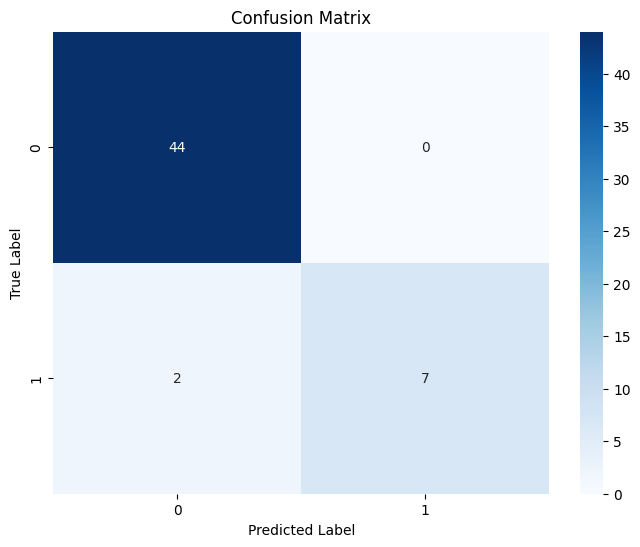

In [42]:
# Evaluate the model on validation set
eval_results = trainer.evaluate(encoded_dataset['test'])

# Print metrics
print(f"Accuracy: {eval_results['eval_accuracy']}")
print(f"Precision: {eval_results['eval_precision']}")
print(f"Recall: {eval_results['eval_recall']}")
print(f"F1-score: {(2 * eval_results['eval_precision'] * eval_results['eval_recall']) / (eval_results['eval_precision'] + eval_results['eval_recall'])}")
print(f"ROC-AUC score: {eval_results['eval_auc_roc']}")
print(f"Log Loss: {eval_results['eval_loss']}")

# Plot Confusion Matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get predictions and labels
preds = trainer.predict(encoded_dataset['test'])
y_pred = np.argmax(preds.predictions, axis=1)
y_true = preds.label_ids

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [43]:
# Decode the tokenized validation sequences back to the original sequences
decoded_sequences = tokenizer.batch_decode(encoded_dataset["test"]["input_ids"], skip_special_tokens=True)

print("\nAll sequences from the validation set with actual and predicted labels:")
for i, sequence in enumerate(decoded_sequences):
    actual = y_true[i]  # True label
    predicted = y_pred[i]  # Predicted label
    
    print(f"Sequence: {sequence[:50]}...")  # Show the first 50 characters for brevity
    print(f"Actual: {actual}, Predicted: {predicted}\n")



All sequences from the validation set with actual and predicted labels:
Sequence: M L Q D I F L K N I L S I Q E N V Y K Y N P V K L ...
Actual: 0, Predicted: 0

Sequence: M S F K L L A I R P L D G C N E K F L K N L E E N ...
Actual: 0, Predicted: 0

Sequence: M R M K H L I A A A L T A L T L S G C S L V Y R I ...
Actual: 1, Predicted: 1

Sequence: M R L G K Q K N K P T D G T T I F E E M K L A R Q ...
Actual: 0, Predicted: 0

Sequence: M S V L S G K K I I L G V T G G I A A Y K S A S L ...
Actual: 0, Predicted: 0

Sequence: M K A I Y I K H L L D F K R P A G T S R G I L N Q ...
Actual: 0, Predicted: 0

Sequence: M L K K I L L L S L G T F A L C F A L Y F A L L Y ...
Actual: 0, Predicted: 0

Sequence: M E Q Q Q Q G E I A V A T E A G L K R R H V H K F ...
Actual: 0, Predicted: 0

Sequence: M S S F D V V V I G S G P G G Y V A A I R C A Q L ...
Actual: 0, Predicted: 0

Sequence: M Q L Q P G V F R L N P I L L S L G L F A L P G L ...
Actual: 1, Predicted: 1

Sequence: M L Q D I F L K N I L S I Q